<a href="https://colab.research.google.com/github/AnandKhandekar/Gibbs-Sampling--Straight-Line/blob/master/Gibbs_Sampler_Fit_Straight_Line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://accarnall.github.io/gibbs_sampling_straight_line/

This is the github page referred to for generating Samples to Fit a straight Line using GIBB's Sampling


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [0]:
error_floor = 0.25    # Set the minimum error for each measurement.

m=1
c=5

x_vals = np.arange(1, 11).astype(float)   #[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
y_vals = m*x_vals + c          #[ 6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]

y_errs = 1. + np.random.randn(10)**2
y_vals += y_errs*np.random.randn(10)

x = np.arange(0, 11, 0.01) # creates x.shape(1100,) values of x between 0 and 11 at equal intervals 0.01

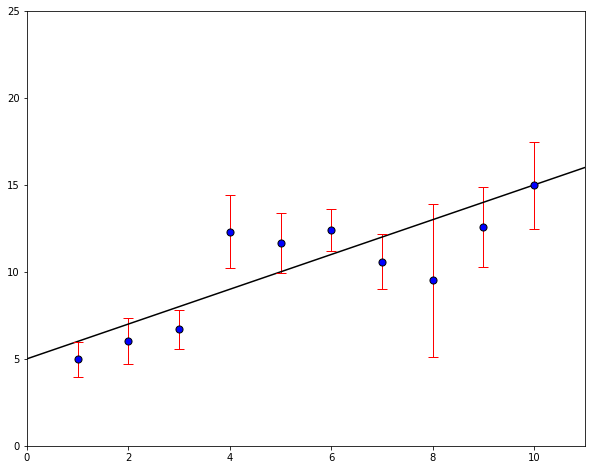

In [19]:
# Plot the data
plt.figure(figsize=(10, 8))
plt.xlim(0, 11)
plt.ylim(0, 25)
plt.plot(x, m*x + c, color="black")
plt.errorbar(x_vals, y_vals, y_errs, ls="", capsize=5, color="red", lw=1)
plt.scatter(x_vals, y_vals, color="blue", lw=1, edgecolor="black", zorder=10, s=50)
plt.show()

> Now imagine we have no knowledge of the input  m  and  c  values, only the blue mock data points we randomly generated. How would we go about fitting a straight line model  y=mx+c  to these data with Gibbs sampling?

#Setting up our model
First things first let's think about what we want to know. We're interested in the posterior distributions for our model parameters,  m  and  c , given the data,  {yi} , along with the corresponding  x  values,  {xi}  and uncertainties  {σi} . This can be written  P(m, c | {yi}) , and can be expanded using Bayes equation to give
* $P(m,\ c\ |\ \{y_i\}) = \dfrac{P(\{y_i\}|\ m,\ c)\ P(m,\ c)}{P(\{y_i\})}$

We don't need the normalisation of this distribution to be able to sample from it, just the dependencies on our model parameters. Therefore, since our  {yi}  are fixed, we can drop the denominator to give:
* $P(m,\ c\ |\ \{y_i\}) \propto P(\{y_i\}|\ m,\ c)\ P(m,\ c)$

Our uncertainties are Gaussian, so we can write down our likelihood function

* $P(\{y_i\}|\ m,\ c) = \prod_i \dfrac{1}{\sqrt{2\pi\sigma_i^2}}\rm{exp}\bigg( -\dfrac{(y_i - mx_i - c)^2}{2\sigma_i^2} \bigg)$

We also need to decide on a prior for  m  and  c . In this instance we'll just use uniform priors for simplicity, so

* $P(m,\ c) \propto 1$

We can now write our posterior distribution (remembering that our  σi  are fixed, so we can drop the prefactor on the likelihood)

* $P(m,\ c\ |\ \{y_i\}) \propto \rm{exp}\bigg( -\sum_i \dfrac{(y_i - mx_i - c)^2}{2\sigma_i^2} \bigg)$

ormally we'd just throw this into a MCMC routine to obtain samples, however in this case we'll use Gibbs sampling instead.

#Setting up our Gibbs sampler
To obtain samples from the joint distribution of our model parameters given our data, Gibbs sampling relies on sampling from the conditional distribution for each parameter in turn. In this case these conditional distributions are  $P(m | c, {y_i}) \ and\  P(c | m, {y_i}) $

This can be useful when it is very difficult or impossible to sample from the joint distribution of all model parameters for some reason, e.g. when there are a very large number of them. Most of the time this is only useful if you can write down the conditional distributions in a form which is easy to directly sample from without rejection, e.g. a Gaussian distribution.

First things first we need to write down our conditional distributions. We do this by treating all other model parameters as fixed. We'll continue dropping any constant factors, meaning we can get rid of any terms which don't contain the parameter we're interested in. Let's start off with  m :

* $P(m\ |\ c,\ \{y_i\}) \propto \rm{exp}\bigg( -\sum_i \dfrac{y_i^2 + m^2 x_i^2 + c^2 + 2mcx_i - 2mx_iy_i - 2cy_i}{2\sigma_i^2} \bigg) \propto \rm{exp}\bigg( -\sum_i \dfrac{m^2 x_i^2 + 2mcx_i - 2mx_iy_i}{2\sigma_i^2} \bigg)$

We can get this into the form of a Gaussian by completing the square inside the exponential to turn our expression of the form  $am^2+bm$  into one of the form  $a(m−h)^2$ . The form of h is a standard result: $ h=\frac{−b}{2a}$. Doing this conversion results in 
* $h = \dfrac{\sum_i \bigg(\dfrac{x_i y_i}{\sigma_i^2}\bigg) - c \sum_i \bigg(\dfrac{x_i}{\sigma_i^2}\bigg)}{\sum_i \bigg(\dfrac{x_i^2}{\sigma_i^2}\bigg)}$

and a probability distribution of the form

* $P(m\ |\ c,\ \{y_i\}) \propto \rm{exp}\Bigg( -\dfrac{1}{2} \sum_i \bigg(\dfrac{x_i^2}{\sigma_i^2}\bigg) (m - h)^2 \Bigg)$

This is a Gaussian with mean,  $μ_m=h$  and standard deviation, $\sigma_m = \bigg(\sum_i\dfrac{x_i^2}{\sigma_i^2}\bigg)^{-\dfrac{1}{2}}$

This is very easy to sample from!

*  $\mu_c = \dfrac{\sum_i \bigg(\dfrac{y_i}{\sigma_i^2}\bigg) - m \sum_i \bigg(\dfrac{x_i}{\sigma_i^2}\bigg)}{\sum_i \bigg(\dfrac{1}{\sigma_i^2}\bigg)}\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \sigma_c = \bigg(\sum_i\dfrac{1}{\sigma_i^2}\bigg)^{-\dfrac{1}{2}}$

We now have conditional distributions for each of our model parameters, both of which are Gaussians. Now we can code up our Gibbs sampler.



***
# CODE for the GIBB's Sampler

first let's write two functions to sample from each of our conditional distributions. Each function takes a vector, param, which contains the current values of both parameters.

In [0]:
def sample_m(param):

    c=param[1]

    mu_m_num = (np.sum(y_vals*x_vals/y_errs**2)- c* np.sum(x_vals/y_errs**2))
    mu_m_den = np.sum(x_vals**2/y_errs**2)

    mu_m = mu_m_num/mu_m_den
    sigma_m = 1./np.sqrt(mu_m_den**2)

    return sigma_m*np.random.randn() + mu_m

In [0]:
def sample_c(param):

    m = param[0]

    mu_c_num = np.sum(y_vals/y_errs**2) - m*np.sum(x_vals/y_errs**2)
    mu_c_den = np.sum(1./y_errs**2)

    mu_c = mu_c_num/mu_c_den
    sigma_c = 1./np.sqrt(mu_c_den)

    return sigma_c*np.random.randn() + mu_c


Now we're ready to sample from our joint distribution by sampling from our conditional distributions. We'll sample from each conditional distribution in turn and call this one full step of our walker. In order to increase our efficiency we'll randomise the order in which we sample our conditional distributions in each step.



In [0]:
n_samples = 11000       # Number of steps we will take
param = np.zeros(2)     # Starting parameter values

# Vectors to hold our samples
m_samp = np.zeros(n_samples)
c_samp = np.zeros(n_samples)

for i in range(1, n_samples):
    param_order = np.random.choice(np.arange(2), 2, replace=False)

    for k in param_order:
        if k == 0:
            m_samp[i] = sample_m(param)
            param[0] = np.copy(m_samp[i])

        else:
            c_samp[i] = sample_c(param)
            param[1] = np.copy(c_samp[i])

Let's take a look at how we did. First we'll plot the trace of the walker. The starting point is shown in blue and the true values in green.

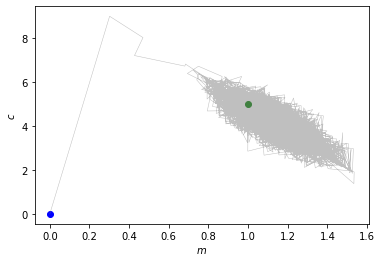

In [25]:
plt.figure()
plt.scatter(m_samp[0], c_samp[0], color="blue")
plt.scatter(m, c, color="green")
plt.plot(m_samp, c_samp, color="gray", alpha=0.5, lw=0.5)
plt.xlabel("$m$")
plt.ylabel("$c$")
plt.show()

Now the individual parameter posterior distributions, discounting the first thousand steps as a burn-in period.

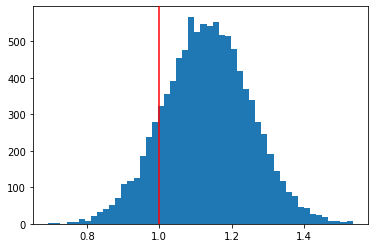

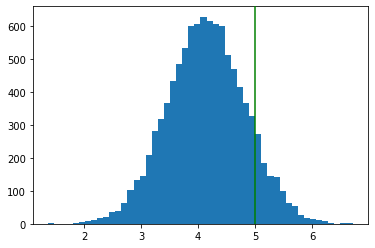

In [27]:
m_samp_burn = m_samp[1000:]
c_samp_burn = c_samp[1000:]

plt.figure()
plt.hist(m_samp_burn, bins=50)
plt.axvline(m, color="red", zorder=10)
plt.show()

plt.figure()
plt.hist(c_samp_burn, bins=50)
plt.axvline(c, color="green", zorder=10)
plt.show()

Finally let's look at the 1-sigma range for the posterior distribution of the model we fitted.

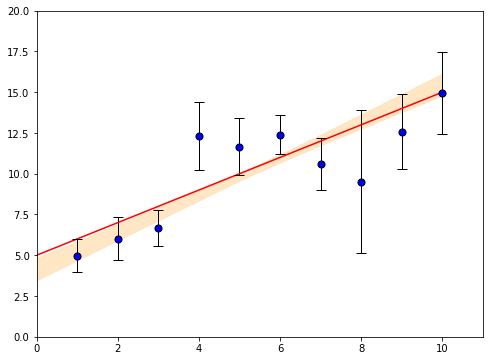

In [29]:
x = np.arange(0, 10, 0.01)

y_posterior = np.expand_dims(x, 1)*m_samp_burn + c_samp_burn

y_quantiles = np.percentile(y_posterior, (16, 84), axis=1)

plt.figure(figsize=(8, 6))
plt.xlim(0, 11)
plt.ylim(0, 20)
plt.fill_between(x, y_quantiles[0,:], y_quantiles[1,:], color="navajowhite", alpha=0.7)
plt.plot(x, m*x + c, color="red")
plt.errorbar(x_vals, y_vals, y_errs, ls="", capsize=5, color="black", lw=1)
plt.scatter(x_vals, y_vals, color="blue", lw=1, edgecolor="black", zorder=10, s=50)
plt.show()